In [73]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.mlab as mlab
import h5py
import glob
from scipy.ndimage import gaussian_filter

In [74]:
# Read the LIGO data (this is exactly like prof. Sievers code)
def read_template(filename):
    dataFile=h5py.File(filename,'r')
    template=dataFile['template']
    th=template[0]
    tl=template[1]
    return th,tl
def read_file(filename):
    dataFile=h5py.File(filename,'r')
    dqInfo=dataFile['quality']['simple']
    qmask=dqInfo['DQmask'][...]

    meta=dataFile['meta']
    gpsStart=meta['GPSstart'].value
    #print meta.keys()
    utc=meta['UTCstart'].value
    duration=meta['Duration'].value
    strain=dataFile['strain']['Strain'].value
    dt=(1.0*duration)/len(strain)

    dataFile.close()
    return strain,dt,utc

In [75]:
# Data of the first gravitational wave detection :) So cool

[datah, dth, utch] = read_file('data/H-H1_LOSC_4_V2-1126259446-32.hdf5')
[datal, dtl ,utcl] = read_file('data/L-L1_LOSC_4_V2-1126259446-32.hdf5')
[th, tl] = read_template('data/GW150914_4_template.hdf5')


<ipython-input-74-3020e7aa6b7a>:14: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  gpsStart=meta['GPSstart'].value
<ipython-input-74-3020e7aa6b7a>:16: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  utc=meta['UTCstart'].value
<ipython-input-74-3020e7aa6b7a>:17: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  duration=meta['Duration'].value
<ipython-input-74-3020e7aa6b7a>:18: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  strain=dataFile['strain']['Strain'].value


# Part A

In [76]:
# This is to define the time points
time = np.zeros(len(datah)) + dth
time[0] = 0
time = np.cumsum(time)

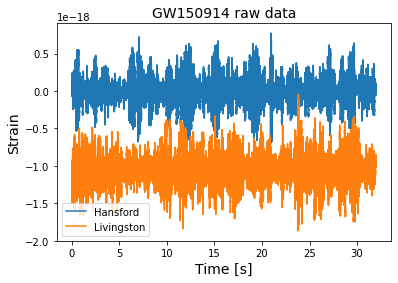

In [77]:
# Plot raw data
plt.plot(time, datah, label = 'Hansford')
plt.plot(time, datal, label = 'Livingston')
plt.title('GW150914 raw data', fontsize = 14)
plt.xlabel("Time [s]", fontsize = 14)
plt.ylabel('Strain', fontsize = 14)
plt.legend()
plt.show()

As expected, it's impossible to see any kind of signal without a good noise model :( 

In [78]:
#Using a Nuttall window (Nuttal window has very little power spread out so this will be more beneficial for us)
x = np.zeros(len(datah))+1
x[0] = 0
x = np.cumsum(x)

N = len(datah)
ao = 0.355768
a1 = 0.487396
a2 = 0.144232
a3 = 0.012604
window = ao - a1*np.cos(2*np.pi*x/N) + a2*np.cos(4*np.pi*x/N) - a3*np.cos(6*np.pi*x/N)

In [79]:
# Now we window everything in FT space
FTth = np.fft.rfft(th*window)
FTtl = np.fft.rfft(tl*window)
FTh = np.fft.rfft(datah*window)
FTl = np.fft.rfft(datal*window)

freq = np.fft.fftshift(np.fft.fftfreq(len(FTh),dth)) # Find the frequency and have to shift it for it to make sense

In [80]:
# Filter the data so that the noise is smoothed out
PSh_raw = (np.abs(FTh)**2) # Might use it later so might as well assigne it to a variable
PSl_raw = (np.abs(FTl)**2) # Might use it later so might as well assigne it to a variable
PSh = gaussian_filter(PSh_raw, 10)
PSl = gaussian_filter(PSl_raw, 10)

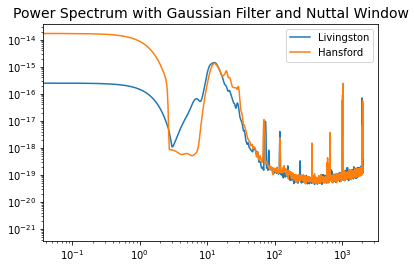

In [81]:
# Plotting the PS with the appropiarte frequncies the shift is PS is so they match on the plot
plt.close
plt.loglog(freq, np.sqrt(np.fft.fftshift(PSh)), label = 'Livingston') 
plt.loglog(freq, np.sqrt(np.fft.fftshift(PSl)), label = 'Hansford')
plt.title('Power Spectrum with Gaussian Filter and Nuttal Window', fontsize = 14)
plt.legend()
plt.show()

# Part B

In [82]:
# Whitening our data (by dividing by the sqrt of our noise model)
# Hansford Data
white_datah_fourier = FTh/np.sqrt(PSh)
white_datah = np.fft.irfft(white_datah_fourier)
white_th_fourier = FTth/np.sqrt(PSh)
white_th = np.fft.irfft(white_th_fourier)
waveh_fourier = white_datahF*np.conj(white_th_fourier)
waveh = np.fft.irfft(waveh_fourier)
waveh = np.fft.fftshift(waveh)

In [83]:
# Livingston Data
white_datal_fourier = FTl/np.sqrt(PSl)
white_datal = np.fft.irfft(white_datal_fourier)
white_tl_fourier = FTtl/np.sqrt(PSl)
white_tl = np.fft.irfft(white_tl_fourier)
wavel_fourier = white_datal_fourier*np.conj(white_tl_fourier)
wavel = np.fft.irfft(wavel_fourier)
wavel = np.fft.fftshift(wavel)

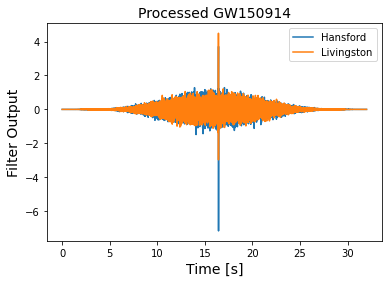

In [84]:
plt.plot(time, waveh, label = 'Hansford')
plt.plot(time, wavel, label = 'Livingston')
plt.xlabel('Time [s]', fontsize = 14)
plt.ylabel("Filter Output", fontsize = 14)
plt.title('Processed GW150914', fontsize = 14)
plt.legend()
plt.show()

# Part C

In [85]:
# The signal to noise (SNR) will be determined by the sqrt of dividing the square of the fourier transform 
# of the template by the power spectrum 

SNRh=np.fft.irfft(np.sqrt((FTth**2)/PSh))
SNRl=np.fft.irfft(np.sqrt((FTtl**2)/PSl))

# Have to shift them afterwards to get the time correctly
SNRh=np.fft.fftshift(SNRh) 
SNRl=np.fft.fftshift(SNRl)

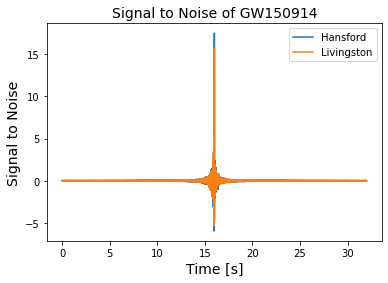

In [86]:
plt.plot(time, SNRh, label = 'Hansford')
plt.plot(time, SNRl, label = 'Livingston')
plt.xlabel('Time [s]', fontsize = 14)
plt.ylabel('Signal to Noise', fontsize = 14)
plt.title('Signal to Noise of GW150914', fontsize = 14)
plt.legend()
plt.show()

# Part D

In [87]:
# Finding the location of the wave assuming its the highest point in the peak

index_h = np.argmax(waveh) 
SNRmeh = waveh[index_h]/np.std(waveh[index_h - 1000 : index_h + 1000])
print('With anyltic signal to noise: ', np.max(SNRh), ', we get: ', SNRmeh, 'for Hansford')

index_l = np.argmax(wavel)
SNRmel = wavel[index_l]/np.std(wavel[index_l - 1000 : index_l + 1000])
print('With anyltic signal to noise: ', np.max(SNRl), ', we get: ', SNRmel, 'for Livingston')


With anyltic signal to noise:  17.462313633042903 , we get:  5.432592882270027 for Hansford
With anyltic signal to noise:  15.714840875614112 , we get:  9.242112188980922 for Livingston


We see a lower SNR for the analytic case because we assumed a perfect noise model, which is not the case in real life. In fact, this analytic SNR is the ideal one because in real life the constructed noise model will not fully describe the noise in the signal.

# Part E

In [88]:
PSh_partE = np.abs(white_datahF)**2
PSl_partE = np.abs(white_datalF)**2

PSh_scaled = np.cumsum(PSh_partE)/np.sum(PSh_partE)
PSl_scaled = np.cumsum(PSl_partE)/np.sum(PSl_partE)

th_halfpoint = np.argmin(np.abs(PSh_scaled - 1/2))
tl_halfpoint = np.argmin(np.abs(PSl_scaled - 1/2))

print('The half way points are at', np.abs(freq[th_halfpoint]), 'Hz and', np.abs(freq[tl_halfpoint]), 'Hz')

The half way points are at 0.8124876024230587 Hz and 18.874711994751056 Hz


# Part F

In [89]:
print(utch)

b'2015-09-14T09:50:30'


This translated to September 14, 2015 at 09:50 UTC

In [90]:
print('The event was measured at', time[index_h], 'in Hansford')
print('the event was measured at', time[index_l], 'in Livingston')

The event was measured at 16.43701171875 in Hansford
the event was measured at 16.431640625 in Livingston


In [91]:
uncertainty_time = np.abs(time[index_h] - time[index_l])
uncertainty_pos = 3*10**8 * uncertainty_time
print('The time uncertainty: ', uncertainty)
print('The position uncertainty: ', uncertainty_pos)

The time uncertainty:  0.00537109375
The position uncertainty:  1611328.125
